In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
os.chdir('..')

In [4]:
from src.loader import NewsDataLoader
import src.countries_region as countries_region 

In [5]:
from src.config import cfg

Output File: news_output.csv
Path: data
News Data: rating.csv
Traffic Data: trafiic.csv
Domain Location Data: domains_location.csv


In [6]:
import src.utils as utils

In [7]:
news_data_loader = NewsDataLoader(cfg.path)

In [8]:
# get news csv file
news = news_data_loader.get_news()

# get traffic csv file
traffic = news_data_loader.get_traffic()

# get domain location data csv file
domain = news_data_loader.get_domain_location()

In [9]:
df = pd.read_csv(news)
traffic_df = pd.read_csv(traffic)
domain_df = pd.read_csv(domain)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58356 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58356 non-null  int64 
 1   source_id        17771 non-null  object
 2   source_name      58356 non-null  object
 3   author           56193 non-null  object
 4   title            58356 non-null  object
 5   description      58346 non-null  object
 6   url              58356 non-null  object
 7   url_to_image     54905 non-null  object
 8   published_at     58356 non-null  object
 9   content          58356 non-null  object
 10  category         58335 non-null  object
 11  article          58356 non-null  object
 12  title_sentiment  58356 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.8+ MB


In [11]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   GlobalRank      1000000 non-null  int64 
 1   TldRank         1000000 non-null  int64 
 2   Domain          1000000 non-null  object
 3   TLD             1000000 non-null  object
 4   RefSubNets      1000000 non-null  int64 
 5   RefIPs          1000000 non-null  int64 
 6   IDN_Domain      1000000 non-null  object
 7   IDN_TLD         1000000 non-null  object
 8   PrevGlobalRank  1000000 non-null  int64 
 9   PrevTldRank     1000000 non-null  int64 
 10  PrevRefSubNets  1000000 non-null  int64 
 11  PrevRefIPs      1000000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 91.6+ MB


In [12]:
domain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37802 entries, 0 to 37801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SourceCommonName  37802 non-null  object
 1   location          37802 non-null  object
 2   Country           37801 non-null  object
dtypes: object(3)
memory usage: 886.1+ KB


In [13]:
df.isna().sum()

article_id             0
source_id          40585
source_name            0
author              2163
title                  0
description           10
url                    0
url_to_image        3451
published_at           0
content                0
category              21
article                0
title_sentiment        0
dtype: int64

In [14]:
domain_df.isna().sum()

SourceCommonName    0
location            0
Country             1
dtype: int64

In [15]:

traffic_df.isna().sum()

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64

In [43]:
df.dropna(subset=['category'], inplace=True)
domain_df.dropna(subset=['Country'], inplace=True)
df.drop_duplicates(subset=['title'], keep='first')

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58351,781108,NaN,The Indian Express,PTI,"Have done no wrong, only did party work, says ...",The High Court today allowed Shivakumar to wit...,https://indianexpress.com/article/cities/banga...,https://images.indianexpress.com/2023/11/DK-Sh...,2023-11-29 10:57:22,Karnataka Deputy Chief Minister D K Shivakumar...,Home,Karnataka Deputy Chief Minister D K Shivakumar...,Neutral
58352,781129,NaN,Forbes,"Tom Sanderson, Senior Contributor, \n Tom Sand...",FC Barcelona Guarantees $77.6 Million Champion...,FC Barcelona have guaranteed at least $77.6 mi...,https://www.forbes.com/sites/tomsanderson/2023...,https://imageio.forbes.com/specials-images/ima...,2023-11-29 08:41:18,FC Barcelona have guaranteed at least $767.6 m...,Home,FC Barcelona have guaranteed at least $767.6 m...,Neutral
58353,781235,NaN,NPR,Brigid McCarthy,Three hospitals ignored her gravely ill fiancé...,"Forty years ago, Sarah Lubarsky came home from...",https://www.npr.org/2023/11/29/1215016001/heal...,https://media.npr.org/assets/img/2023/11/23/sa...,2023-11-29 10:01:12,The photo from David and Sarah Lubarsky's wedd...,Home,The photo from David and Sarah Lubarsky's wedd...,Negative
58354,781240,NaN,Forbes,"Gary Stern, Contributor, \n Gary Stern, Contri...",Kerber’s Farm: Bringing Farm To Table To Manha...,"A farmstand in Long Island, Kerber’s Farms has...",https://www.forbes.com/sites/garystern/2023/11...,https://imageio.forbes.com/specials-images/ima...,2023-11-29 13:44:33,Kerbers Farm: Bringing Farm To Table To Manhat...,Home,Kerber’s Farm: Bringing Farm To Table To Manha...,Neutral


In [44]:
df.isna().sum()

article_id             0
source_id          40570
source_name            0
author              2160
title                  0
description           10
url                    0
url_to_image        3451
published_at           0
content                0
category               0
article                0
title_sentiment        0
dtype: int64

In [45]:
traffic_df.isna().sum()

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64

In [46]:
domain_df.isna().sum()

SourceCommonName    0
location            0
Country             0
dtype: int64

In [47]:
df.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [48]:
domain_df.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [49]:
traffic_df.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


In [56]:
df["title_sentiment"].value_counts()

Neutral     42909
Negative     9129
Positive     6297
Name: title_sentiment, dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58335 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58335 non-null  int64 
 1   source_id        17765 non-null  object
 2   source_name      58335 non-null  object
 3   author           56175 non-null  object
 4   title            58335 non-null  object
 5   description      58325 non-null  object
 6   url              58335 non-null  object
 7   url_to_image     54884 non-null  object
 8   published_at     58335 non-null  object
 9   content          58335 non-null  object
 10  category         58335 non-null  object
 11  article          58335 non-null  object
 12  title_sentiment  58335 non-null  object
dtypes: int64(1), object(12)
memory usage: 6.2+ MB


In [75]:
# Count the number of articles per source_name
article_counts = df['source_name'].value_counts()

# Get the top 10 websites
top_10_websites = article_counts.head(10)

# Get the bottom 10 websites
bottom_10_websites = article_counts.tail(10)

print("Top 10 websites with the largest count of news articles:")
print(top_10_websites)
print("\nBottom 10 websites with the smallest count of news articles:")
print(bottom_10_websites)

Top 10 websites with the largest count of news articles:
ETF Daily News        16742
The Times of India     7504
GlobeNewswire          5423
Globalsecurity.org     3119
Forbes                 2783
BBC News               2113
ABC News               2055
Business Insider       2033
The Punch              1800
Al Jazeera English     1663
Name: source_name, dtype: int64

Bottom 10 websites with the smallest count of news articles:
CNA                            671
Time                           600
Android Central                522
Gizmodo.com                    388
ReadWrite                      324
Euronews                       286
Wired                          270
CNN                            267
The Verge                      214
AllAfrica - Top Africa News     20
Name: source_name, dtype: int64


In [57]:
# Websites with the highest numbers of visitors traffic 

sorted_df = traffic_df.sort_values('GlobalRank')

# Display the top 10 websites
top_10_websites = sorted_df['Domain'].head(10)

bottom_10_websites = sorted_df['Domain'].tail(10)

print("Top 10 websites with the highest numbers of visitor traffic:\n")
print(top_10_websites)

print("\n\nBottom 10 websites visitor traffic: \n")
print(bottom_10_websites)

Top 10 websites with the highest numbers of visitor traffic:

0              google.com
1            facebook.com
2             youtube.com
3             twitter.com
4           instagram.com
5            linkedin.com
6               apple.com
7           microsoft.com
8    googletagmanager.com
9           wikipedia.org
Name: Domain, dtype: object


Bottom 10 websites visitor traffic: 

999990              eiretrip.com
999991      exploring-africa.com
999992                  hmag.com
999993            irishcycle.com
999994           keith-baker.com
999995                kireie.com
999996               mt-lock.com
999997             pinkwater.com
999998            soderhomes.com
999999    toyotamusicfactory.com
Name: Domain, dtype: object


In [59]:
# Countries with the highest number of news media organisations (represented by domains in the data)
top10 = domain_df['Country'].value_counts().head(10)

bottom10 = domain_df['Country'].value_counts().tail(10)

print("Top 10 countries with the highest number of news media organisations:\n")
print(top10)
print("\n\nBottom 10 countries with the lowest number of news media organisations:\n")
print(bottom10)


Top 10 countries with the highest number of news media organisations:

United States     14111
United Kingdom     1950
Italy              1810
France             1041
Russia             1024
Canada              887
Germany             884
China               780
Turkey              725
India               686
Name: Country, dtype: int64


Bottom 10 countries with the lowest number of news media organisations:

Greenland         1
Guernsey          1
Isle of Man       1
Cook Islands      1
Guinea-Bissau     1
Micronesia        1
Aruba             1
American Samoa    1
Guadeloupe        1
Saint Helena      1
Name: Country, dtype: int64


In [60]:
# Countries that have many articles written about them
category = df['category'].value_counts()
countries = domain_df['Country'].unique()
country_categories = category[category.index.isin(countries)]
print("Top 10\n")
print(country_categories.head(10))
print("\nBottom 10\n")
print(country_categories.tail(10))

Top 10

Canada            2066
India             1054
Australia          877
United Kingdom     753
Ukraine            577
Mexico             553
United States      481
Nigeria            469
Germany            459
Hong Kong          430
Name: category, dtype: int64

Bottom 10

Turkmenistan    8
Montserrat      7
Bhutan          7
Eritrea         6
San Marino      4
Gambia          4
Andorra         3
Burundi         3
Honduras        3
Martinique      2
Name: category, dtype: int64


In [64]:
# Websites that reported (the news content) about Africa
region = countries_region.get_region()

df['Region'] = df['category'].map(region)

africa = df[df['Region'] == 'Africa']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about Europe

europe = df[df['Region'] == 'Europe']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about Asia

asia = df[df['Region'] == 'Asia']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about North America

north_america = df[df['Region'] == 'America']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about China

china = df[df['Region'] == 'China']['source_name'].value_counts().head(10)

print("Top 10 websites that reported news content about Africa:\n")
print(africa)
print("\nTop 10 websites that reported news content about Europe:\n")
print(europe)
print("\nTop 10 websites that reported news content about Asia:\n")
print(asia)
print("\nTop 10 websites that reported news content about North America:\n")
print(north_america)
print("\nTop 10 websites that reported news content about China:\n")
print(china)


Top 10 websites that reported news content about Africa:

The Punch                       835
Marketscreener.com              242
The Times of India              203
ETF Daily News                  190
Globalsecurity.org              190
BBC News                        138
RT                              130
Al Jazeera English              116
ABC News                        105
International Business Times     97
Name: source_name, dtype: int64

Top 10 websites that reported news content about Europe:

ETF Daily News        958
GlobeNewswire         496
Globalsecurity.org    485
RT                    251
The Times of India    249
ABC News              204
Business Insider      192
Al Jazeera English    179
Euronews              147
BBC News              121
Name: source_name, dtype: int64

Top 10 websites that reported news content about Asia:

The Times of India              1451
Globalsecurity.org               603
Al Jazeera English               377
ETF Daily News                 

In [74]:
#Websites with the highest count of positive sentiment news articles
positive = df[df['title_sentiment'] == 'Positive']['source_name'].value_counts().head(10)

#websites with the highest count of negative sentiment news articles
negative = df[df['title_sentiment'] == 'Negative']['source_name'].value_counts().head(10)

#websites with the highest count of neutral sentiment news articles
neutral = df[df['title_sentiment'] == 'Neutral']['source_name'].value_counts().head(10)

print("Top 10 websites with the highest count of positive sentiment news articles:\n")
print(positive)
print("\nTop 10 websites with the highest count of negative sentiment news articles:\n")
print(negative)
print("\nTop 10 websites with the highest count of neutral sentiment news articles:\n")
print(neutral)

Top 10 websites with the highest count of positive sentiment news articles:

The Times of India    1145
ETF Daily News         992
GlobeNewswire          905
Forbes                 635
Digital Trends         406
Android Central        272
Business Insider       237
Boing Boing            170
Marketscreener.com     153
Phys.Org               143
Name: source_name, dtype: int64

Top 10 websites with the highest count of negative sentiment news articles:

The Times of India              1210
Business Insider                 890
BBC News                         854
Globalsecurity.org               747
ABC News                         725
Al Jazeera English               706
ETF Daily News                   560
The Punch                        455
RT                               403
International Business Times     318
Name: source_name, dtype: int64

Top 10 websites with the highest count of neutral sentiment news articles:

ETF Daily News        15190
The Times of India     5149
GlobeNew

<Axes: >

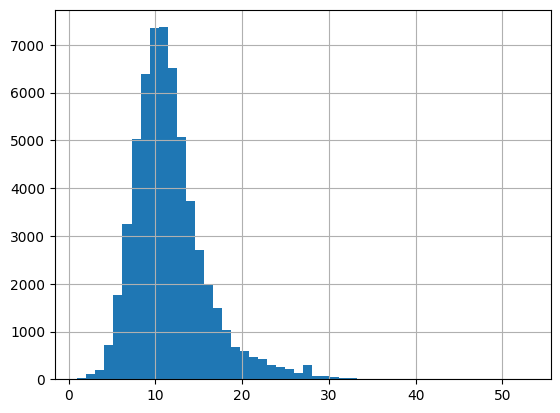

In [79]:
# How similar are the number of words in the title across sites? Check the distribution among sites
df['title_length'] = df['title'].apply(lambda x: len(x.split()))
df['title_length'].describe()
df['title_length'].hist(bins=50)